<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/main/1_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [181]:
manager.train_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/train.csv'

In [182]:
df_source = pd.read_csv(manager.train_path)
df_submission = pd.read_csv(manager.test_path)

In [183]:
df_source.shape, df_submission.shape

((22730, 18), (15154, 17))

# NAN check

In [ ]:
from sklearn_utils import nan_report

_ = nan_report(df_source, 0.0)

0 / 18 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


In [ ]:
_ = nan_report(df_submission, 0.0)

0 / 17 cols (0.0 %) have nan % > 0.0

Series([], dtype: float64)


# INF check

In [ ]:
from sklearn_utils import inf_report

_ = inf_report(df_source, 0.0)
_ = inf_report(df_submission, 0.0)

No infinite values observed
No infinite values observed


# Check outliers before splitting the data

## Visualize outliers

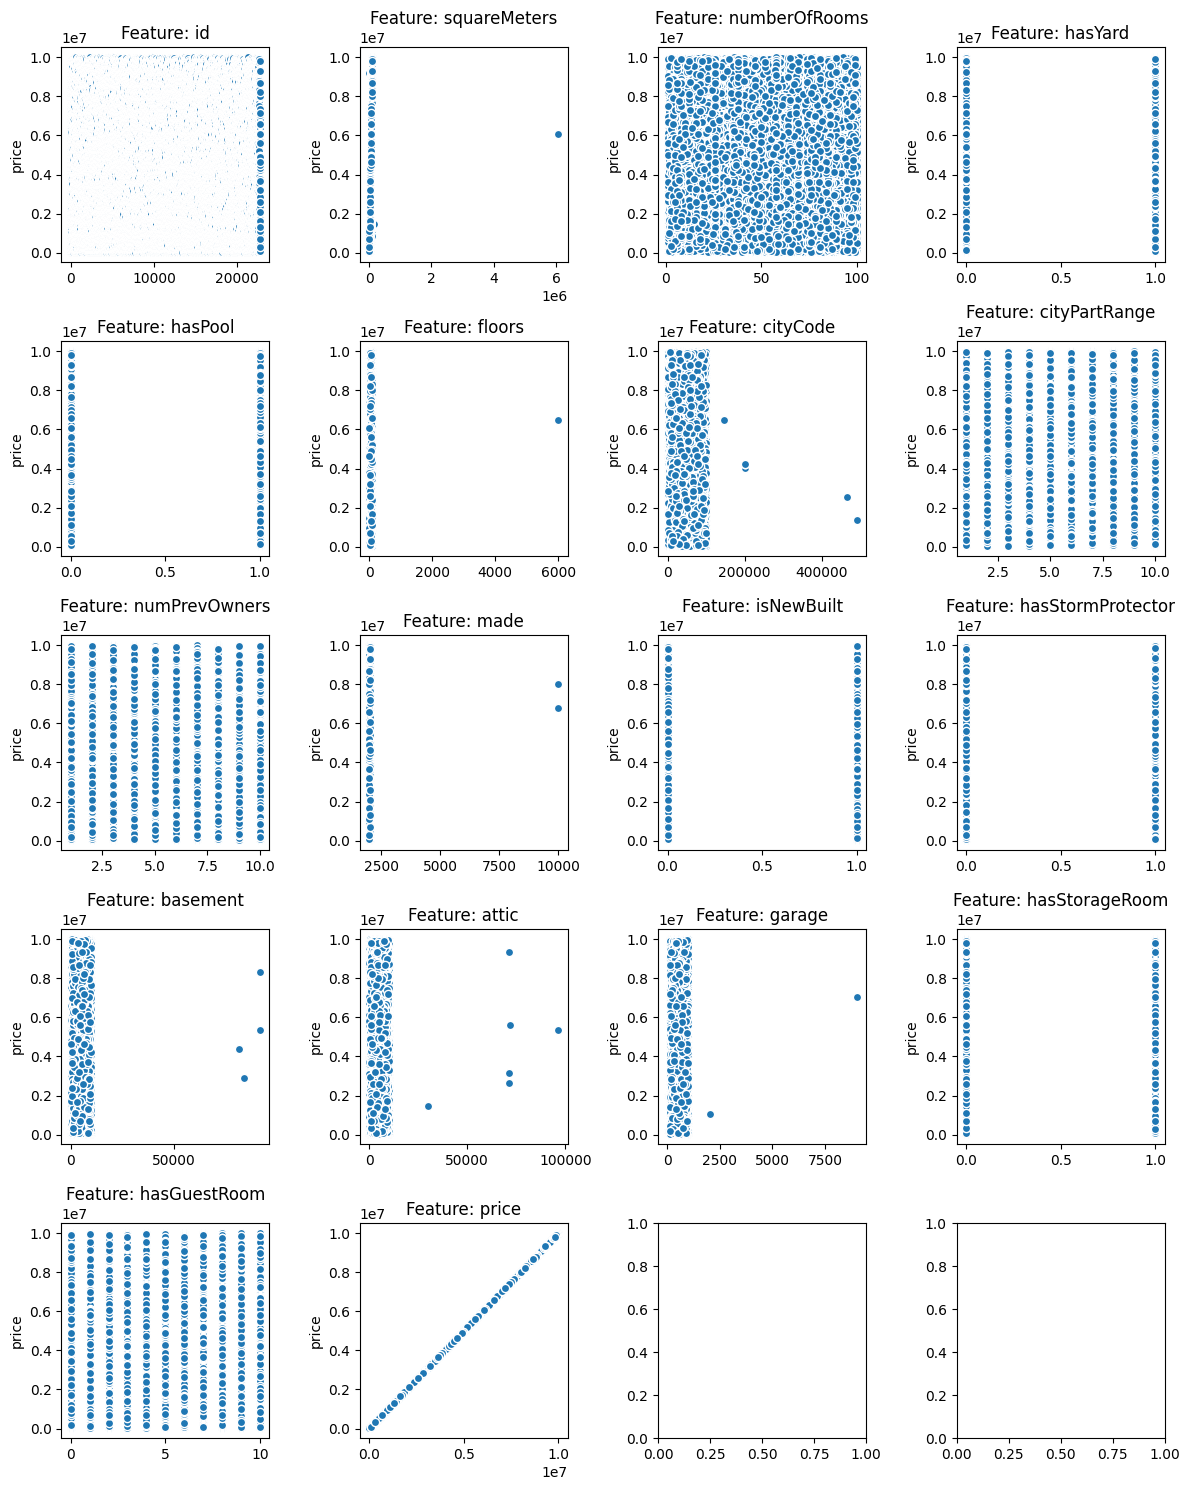

In [6]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## Detect outliers

In [184]:
def find_outlier_indices(df, columns, knn_neighbors, distance_quantile=0.9, figsize=(10, 5)):
    # for regression task
    # https://www.kaggle.com/code/kimchanyoung/simple-anomaly-detection-using-unsupervised-knn
    assert len(columns) == 2

    _, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].scatter(
        x=df[columns[0]],
        y=df[columns[1]],
        color='blue',
        label='data'
    )
    ax[0].set_xlabel(columns[0])
    ax[0].set_ylabel(columns[1])

    outlier_detector = NearestNeighbors(n_neighbors=knn_neighbors)
    print(f'Fitting KNN detector')
    outlier_detector.fit(df[columns])

    distances, indexes = outlier_detector.kneighbors(df_source[columns])
    ax[1].plot(distances.mean(axis=1))
    ax[1].set_title(f'KNN distances')



    distances = pd.DataFrame(distances).mean(axis=1)
    threshold = distances.quantile(distance_quantile)
    outlier_indices = np.where(distances > threshold)[0]
    # print(outlier_indices, columns)
    # outlier_subset = df.loc[outlier_indices, columns]
    outlier_subset = df[np.isin(df.index, outlier_indices)]

    ax[0].scatter(
        x=outlier_subset[columns[0]],
        y=outlier_subset[columns[1]],
        color='red',
        label='outliers'
    )
    ax[0].legend()
    return outlier_indices

Fitting KNN detector
Fitting KNN detector
Fitting KNN detector
Fitting KNN detector
Fitting KNN detector
Fitting KNN detector
Fitting KNN detector


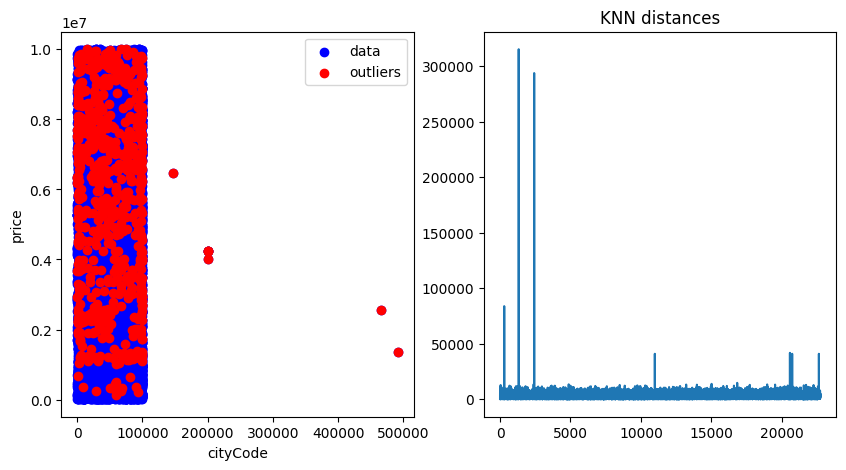

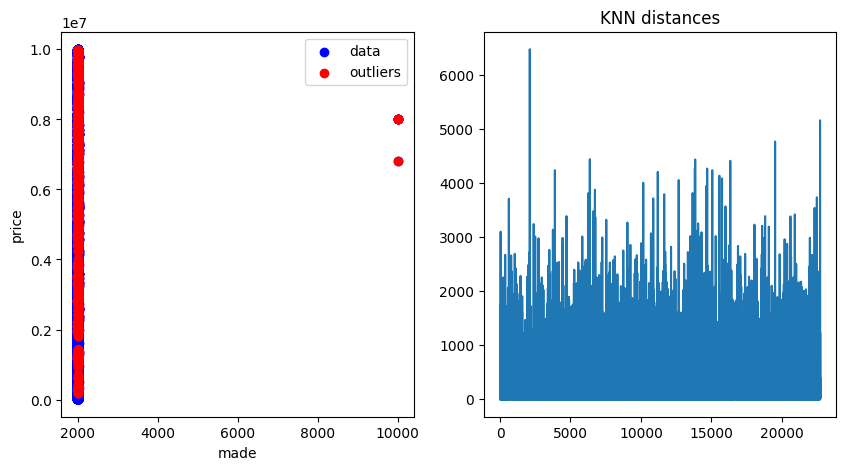

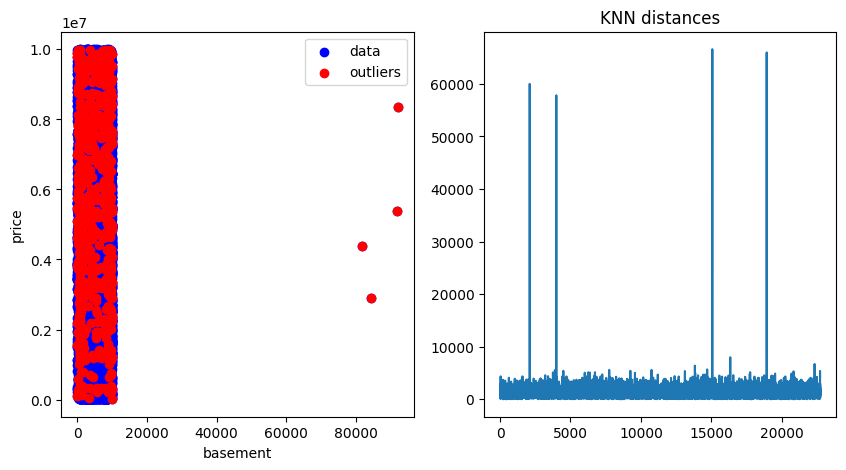

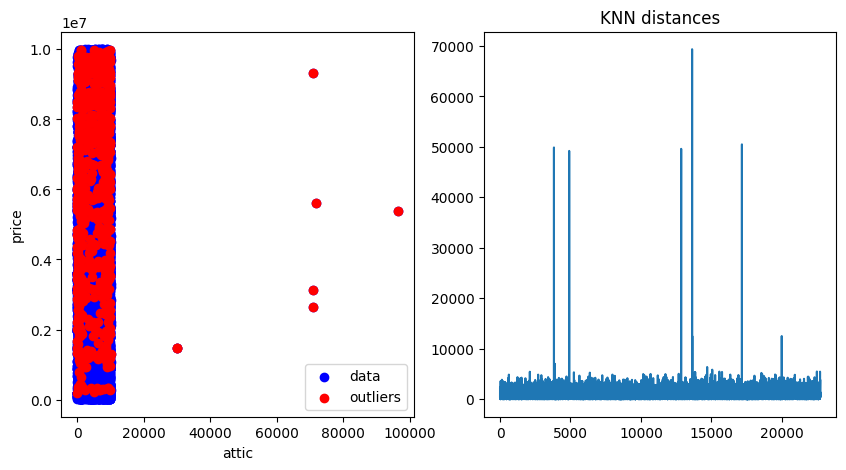

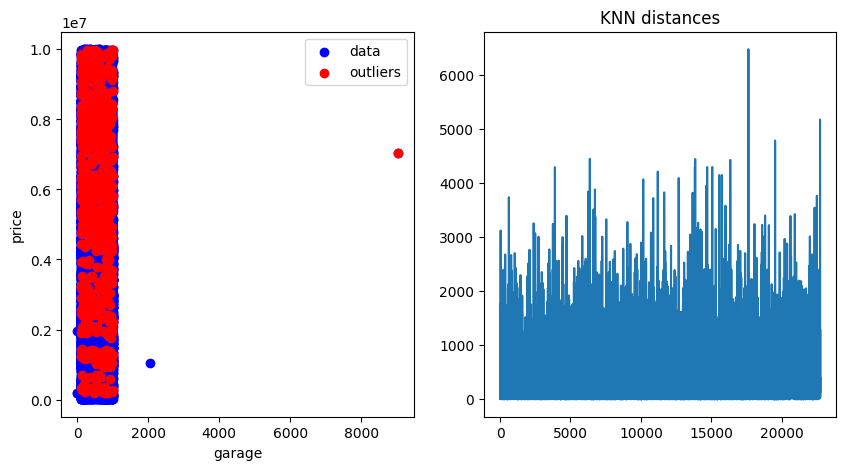

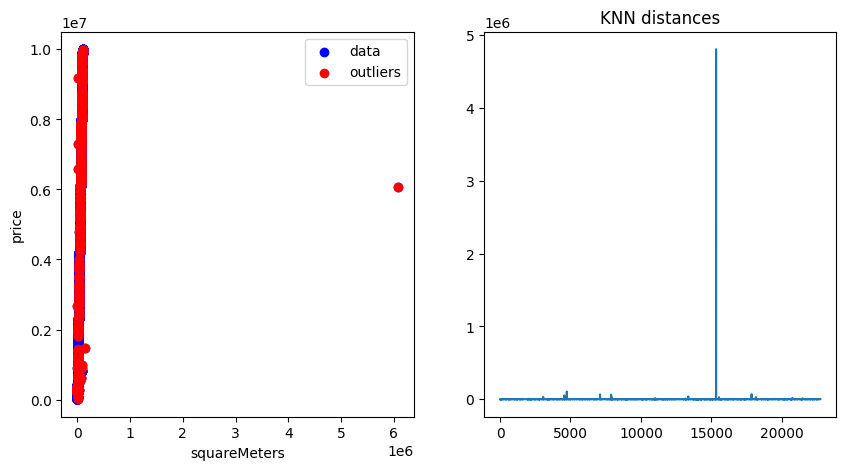

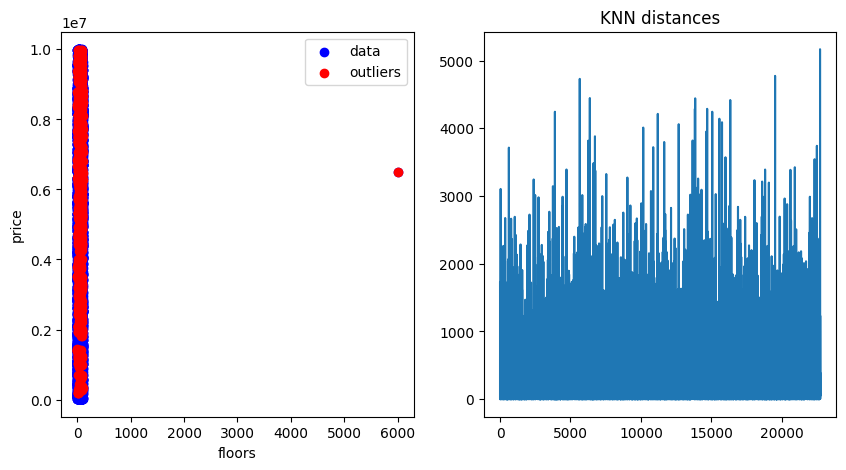

In [185]:
outlier_thresh = 0.97
n_neighbors = 5
total_outliers = set()
for c in ['cityCode', 'made', 'basement', 'attic', 'garage', 'squareMeters', 'floors']:
    outliers = \
        find_outlier_indices(df_source, [c, 'price'], n_neighbors, outlier_thresh)
    for o in outliers:
        total_outliers.add(o)

In [186]:
len(total_outliers) / df_source.shape[0]

0.08460184777826661

In [187]:
print(df_source.shape)
df_source = df_source[~np.isin(df_source['id'], sorted(list(total_outliers)))]
print(df_source.shape)

(22730, 18)
(20807, 18)


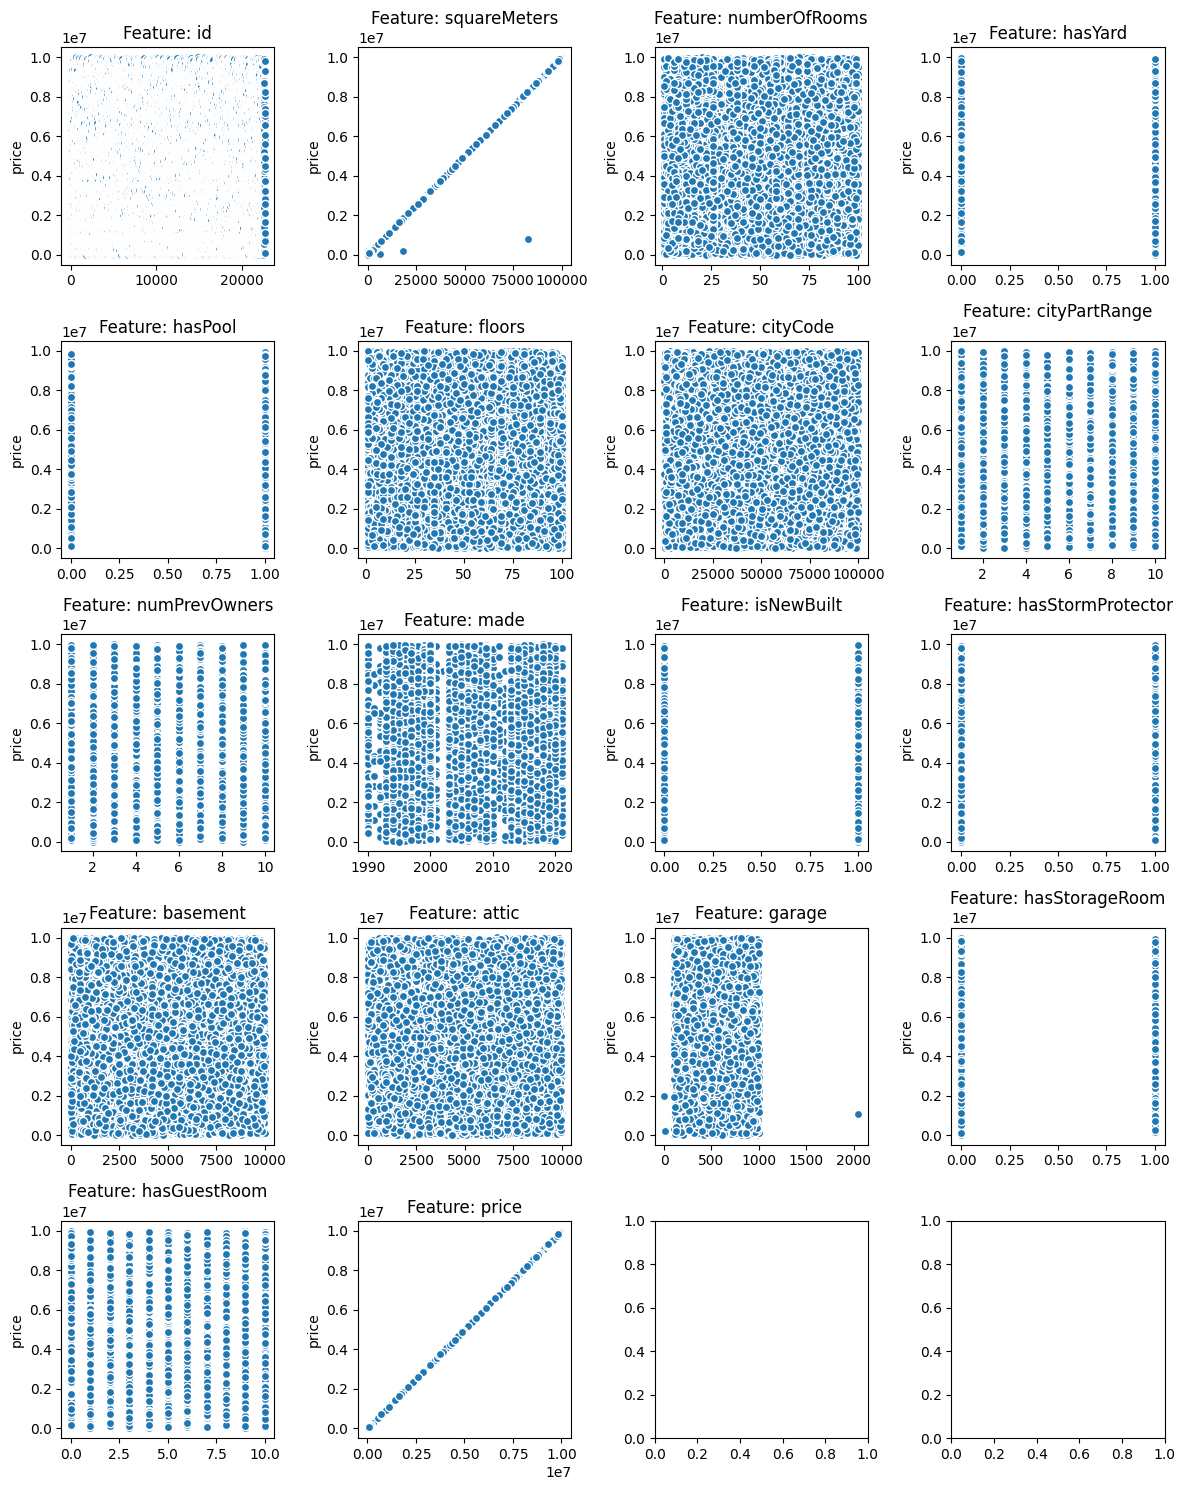

In [188]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

# Split the data

In [ ]:
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8
EXPLORATION_SIZE = 0.5
RANDOM_STATE = 42

In [ ]:
from sklearn.model_selection import train_test_split

df_trainval, df_test = train_test_split(
    df_source,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE
)

df_trainval.shape, df_test.shape

((18184, 18), (4546, 18))

In [ ]:
df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

df_train.shape, df_val.shape

((14547, 18), (3637, 18))

In [ ]:
df_exploration, _ = train_test_split(
    df_train,
    train_size=EXPLORATION_SIZE,
    random_state=RANDOM_STATE
)

df_exploration.shape

(7273, 18)

In [ ]:
def X_Y(df, return_y=True):

    X = df.loc[:, df.columns != 'price']
    if return_y:
        Y = df['price']
        return X, Y
    else:
        return X, None

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)

## Check target distribution

Visualizing datasets distributions
(1, 1) <class 'numpy.ndarray'>


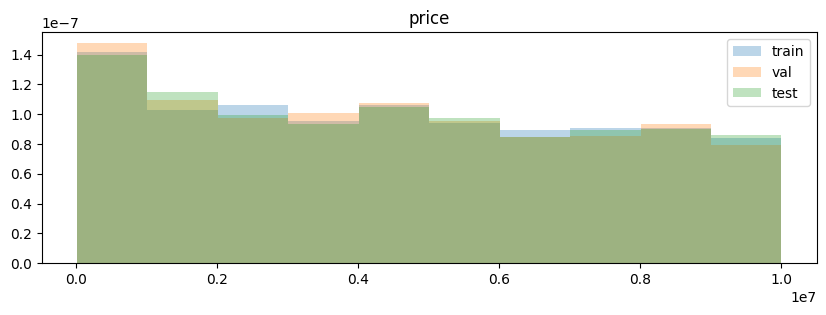

In [ ]:
from sklearn_utils import visualize_datasets_distributions

visualize_datasets_distributions(
    {
        'train': df_train,
        'val': df_val,
        'test': df_test,
    },
    ['price'],
    grid_width=1
)

# Data exploration